In [1]:
%load_ext autoreload
%autoreload 2
import pickle, json
import discovery as ds
import jax
from jax import numpy as jnp

import blackjax

from matplotlib import pyplot as plt

In [2]:
datadir = '/Users/aaron/Documents/NANOGrav/ng_data/15yr_data'
with open(datadir + '/15yr_pint.pkl', 'rb') as fp:
    psrs = pickle.load(fp)

with open(datadir + '/v1p1_wn_dict.json', 'r') as fp:
    wn_params = json.load(fp)

libstempo not installed. Will use PINT instead.


In [3]:
num_psrs = 2
psrs = psrs[:num_psrs]

In [4]:
tspan = ds.getspan(psrs)

In [12]:
# It is twice as fast per iteration to create this object with generator input
gl = ds.GlobalLikelihood((ds.PulsarLikelihood([psrs[ii].residuals,
                                     ds.makenoise_measurement(psrs[ii], wn_params),
                                     ds.makegp_ecorr(psrs[ii], wn_params),
                                     ds.makegp_timing(psrs[ii]),
                                     ds.makegp_fourier(psrs[ii], ds.powerlaw, 30, T=tspan, name='red_noise'),
                                     ds.makegp_fourier(psrs[ii], ds.powerlaw, 14, T=tspan, common=['gw_log10_A', 'gw_gamma'], name='gw')]) for ii in range(len(psrs))))


In [13]:
x0 = ds.prior.sample_uniform(gl.logL.params)
logprior = ds.prior.makelogprior_uniform(gl.logL.params, ds.prior.priordict_standard)
loglike = gl.logL

jlogl = jax.jit(loglike)
jlogp = jax.jit(logprior)

In [14]:
@jax.jit
def logdensity(x):
    # x = map_params(loglike.params, x)
    return jlogp(x) + jlogl(x)

In [15]:
initial_position = ds.prior.sample_uniform(gl.logL.params)
logdensity(initial_position)

Array(419356.6331813, dtype=float64)

In [11]:
%%timeit
logdensity(initial_position)  # ~16 ms per loop

458 µs ± 100 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Use `blackjax` to do some sampling with `nuts`

In [12]:
# input some generic starting parameters
inv_mass_matrix = jnp.zeros(len(jlogl.params)) + 0.5
num_integration_steps = 60
step_size = 1e-3

nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

In [13]:
# set up the loop for nuts
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [14]:
# This cell takes 17m, 16s to run on my laptop
# run a warmup sequence to get the sampler to reasonable starting parameters
rng_key = jax.random.PRNGKey(30)  # initial rng_key
warmup = blackjax.window_adaptation(blackjax.nuts, logdensity, num_steps=1000)
last_chain_state, kernel, warmup_chain = warmup.run(rng_key, initial_position)

In [15]:
last_chain_state

HMCState(position={'B1855+09_red_noise_gamma': Array(4.16466363, dtype=float64, weak_type=True), 'B1855+09_red_noise_log10_A': Array(-14.16318882, dtype=float64, weak_type=True), 'B1937+21_red_noise_gamma': Array(3.66114835, dtype=float64, weak_type=True), 'B1937+21_red_noise_log10_A': Array(-13.5490134, dtype=float64, weak_type=True), 'crn_gamma': Array(4.82621692, dtype=float64, weak_type=True), 'crn_log10_A': Array(-14.69674362, dtype=float64, weak_type=True)}, potential_energy=Array(-419620.96902006, dtype=float64), potential_energy_grad={'B1855+09_red_noise_gamma': Array(0.00369066, dtype=float64, weak_type=True), 'B1855+09_red_noise_log10_A': Array(-1.574818, dtype=float64, weak_type=True), 'B1937+21_red_noise_gamma': Array(-5.83761784, dtype=float64, weak_type=True), 'B1937+21_red_noise_log10_A': Array(-14.39174901, dtype=float64, weak_type=True), 'crn_gamma': Array(-0.16616614, dtype=float64, weak_type=True), 'crn_log10_A': Array(-0.75215021, dtype=float64, weak_type=True)})

In [17]:
# run for 10k iterations
states = inference_loop(rng_key, kernel, last_chain_state, 10000)

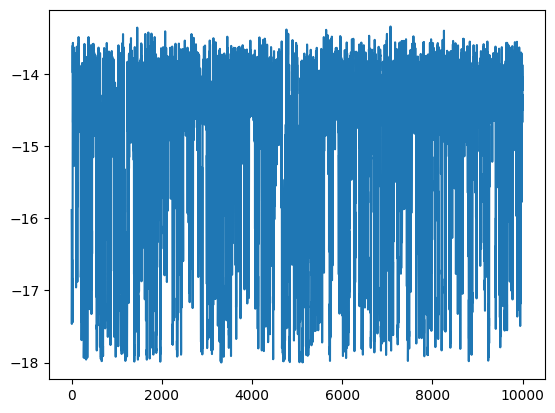

In [19]:
plt.plot(states[0]['crn_log10_A'])

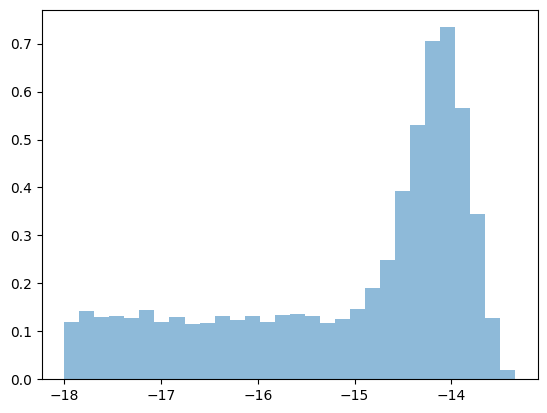

In [24]:
plt.hist(states[0]['crn_log10_A'], bins=30, density=True, alpha=0.5, label='crn_log10_A');

### Compare with `enterprise`

In [16]:
from enterprise_extensions import models

In [17]:
pta = models.model_2a(psrs, noisedict=wn_params, components=30, n_gwbfreqs=14,
               Tspan=tspan, tm_marg=True, tm_svd=True)

In [31]:
vals = []
for i in range(10000):
    initial_position = ds.prior.sample_uniform(gl.logL.params)
    vals.append(pta.get_lnlikelihood(initial_position) - jlogl(initial_position))

In [25]:
initial_position

{'B1855+09_red_noise_gamma': 2.0284275572024884,
 'B1855+09_red_noise_log10_A': -14.296542979030518,
 'B1937+21_red_noise_gamma': 2.186118724833316,
 'B1937+21_red_noise_log10_A': -12.276475904279181,
 'gw_gamma': 6.439152972779656,
 'gw_log10_A': -11.395808126429062}

In [26]:
pta.get_lnlikelihood(initial_position)

KernelMatrix(419198.46343071)

In [27]:
jlogl(initial_position)

Array(419254.02422651, dtype=float64)

In [28]:
pta.param_names

['B1855+09_red_noise_gamma',
 'B1855+09_red_noise_log10_A',
 'B1937+21_red_noise_gamma',
 'B1937+21_red_noise_log10_A',
 'gw_gamma',
 'gw_log10_A']

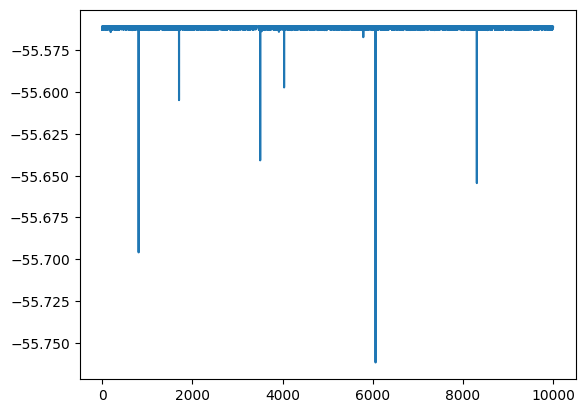

In [32]:
plt.plot(vals)

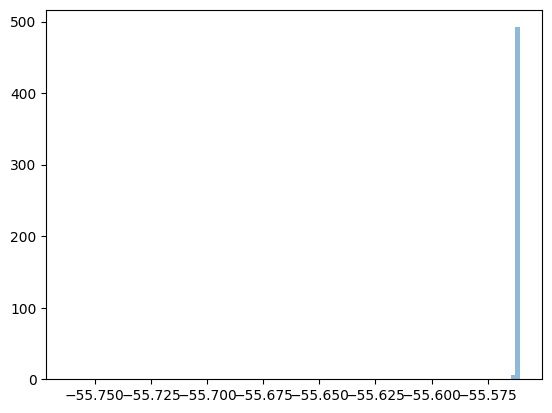

In [33]:
plt.hist(vals, bins=100, density=True, alpha=0.5, label='samples');

### Full HMC run

In [34]:
datadir = '/Users/aaron/Documents/NANOGrav/ng_data/15yr_data'
with open(datadir + '/15yr_pint.pkl', 'rb') as fp:
    psrs = pickle.load(fp)

with open(datadir + '/v1p1_wn_dict.json', 'r') as fp:
    wn_params = json.load(fp)

In [35]:
# It is twice as fast per iteration to create this object with generator input
gl = ds.GlobalLikelihood((ds.PulsarLikelihood([psrs[ii].residuals,
                                     ds.makenoise_measurement(psrs[ii], wn_params),
                                     ds.makegp_ecorr(psrs[ii], wn_params),
                                     ds.makegp_timing(psrs[ii]),
                                     ds.makegp_fourier(psrs[ii], ds.powerlaw, 30, T=tspan, name='red_noise'),
                                     ds.makegp_fourier(psrs[ii], ds.powerlaw, 14, T=tspan, common=['gw_log10_A', 'gw_gamma'], name='gw')]) for ii in range(len(psrs))))

In [36]:
x0 = ds.prior.sample_uniform(gl.logL.params)
logprior = ds.prior.makelogprior_uniform(gl.logL.params, ds.prior.priordict_standard)
loglike = gl.logL

jlogl = jax.jit(loglike)
jlogp = jax.jit(logprior)


In [37]:
@jax.jit
def logdensity(x):
    # x = map_params(loglike.params, x)
    return jlogp(x) + jlogl(x)

In [38]:
initial_position = ds.prior.sample_uniform(gl.logL.params)
logdensity(initial_position)

Array(7928186.11839871, dtype=float64)

In [39]:
# input some generic starting parameters
inv_mass_matrix = jnp.zeros(len(jlogl.params)) + 0.5
num_integration_steps = 60
step_size = 1e-3

nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

In [40]:
# set up the loop for nuts
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [41]:
# This cell takes 17m, 16s to run on my laptop
# run a warmup sequence to get the sampler to reasonable starting parameters
rng_key = jax.random.PRNGKey(30)  # initial rng_key
warmup = blackjax.window_adaptation(blackjax.nuts, logdensity, num_steps=1000)
last_chain_state, kernel, warmup_chain = warmup.run(rng_key, initial_position)

2023-07-30 15:51:01.731939: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-07-30 15:51:05.112810: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m3.387632s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [42]:
# run for 10k iterations
states = inference_loop(rng_key, kernel, last_chain_state, 10000)